In [ ]:
# Keep this cell minimal to avoid early errors
import pandas as pd

In [5]:
gallstone_data = pd.read_excel("dataset-uci.xlsx")
gallstone_data.head()

,Gallstone Status,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,...,High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
0,0,50,0,0,0,0,0,0,185,92.8,...,40.0,134.0,20.0,22.0,87.0,0.82,112.47,0.0,16.0,33.0
1,0,47,0,1,0,0,0,0,176,94.5,...,43.0,103.0,14.0,13.0,46.0,0.87,107.10,0.0,14.4,25.0
2,0,61,0,0,0,0,0,0,171,91.1,...,43.0,69.0,18.0,14.0,66.0,1.25,65.51,0.0,16.2,30.2
3,0,41,0,0,0,0,0,0,168,67.7,...,59.0,53.0,20.0,12.0,34.0,1.02,94.10,0.0,15.4,35.4
4,0,42,0,0,0,0,0,0,178,89.6,...,30.0,326.0,27.0,54.0,71.0,0.82,112.47,0.0,16.8,40.6


# Project 1 — Predicting Gallstone Disease from Clinical + Bioimpedance

"""
Domain: Healthcare | Task: Binary Classification (Gallstone Status)
This notebook performs EDA, preprocessing, modeling (>=3 models), evaluation and basic tuning.
"""


In [ ]:
# 1) Imports and environment checks (updated for Gallstone dataset specifics)
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, classification_report)
import joblib

# Display settings
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (8,5)

# Data path (adjust if needed)
DATA_PATH = "data/dataset-uci.xlsx"
print('DATA_PATH:', DATA_PATH)
print('exists:', os.path.exists(DATA_PATH))

# Helper: convert object columns with comma decimals to numeric
def convert_decimal_commas(df: pd.DataFrame, skip_cols=None) -> pd.DataFrame:
    if skip_cols is None:
        skip_cols = []
    df = df.copy()
    obj_cols = [c for c in df.columns if c not in skip_cols and df[c].dtype == 'O']
    converted = []
    for c in obj_cols:
        s = df[c].astype(str)
        # Try direct numeric
        s_num = pd.to_numeric(s, errors='coerce')
        # If mostly NaN, try comma -> dot
        if s_num.isna().mean() > 0.5:
            s_num = pd.to_numeric(s.str.replace(',', '.', regex=False), errors='coerce')
        # If we got at least some numbers, use it
        if s_num.notna().mean() > 0.5:
            df[c] = s_num
            converted.append(c)
    if converted:
        print(f"Converted object->numeric (comma handling) for {len(converted)} columns: {converted[:8]}{'...' if len(converted)>8 else ''}")
    return df

# Read Excel (sheet name 'dataset' per data card)
try:
    df = pd.read_excel(DATA_PATH, sheet_name='dataset')
    # Fix any odd column typos
    if 'Bone MassBone Mass (BM)' in df.columns:
        df = df.rename(columns={'Bone MassBone Mass (BM)': 'Bone Mass (BM)'})
    # Convert comma decimals
    df = convert_decimal_commas(df)
    print('Read dataframe shape:', df.shape)
except Exception as e:
    print('Error reading excel:', repr(e))
    df = None


DATA_PATH: /data/dataset-uci.xlsx
exists: False
Error reading excel: FileNotFoundError(2, 'No such file or directory')


In [14]:
# 2) Quick data overview
if df is not None:
    display(df.head())
    print('\nShape:', df.shape)
    print('\nColumns and types:')
    print(df.dtypes)
    print('\nTarget value counts:')
    if 'Gallstone Status' in df.columns:
        print(df['Gallstone Status'].value_counts())
    else:
        print('Warning: target column "Gallstone Status" not found. Columns:', df.columns.tolist())

    print('\nMissing values per column:')
    print(df.isnull().sum())
    print('\nDuplicates count:', df.duplicated().sum())
else:
    print('Dataframe not loaded.')


,Gallstone Status,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia,Diabetes Mellitus (DM),Height,Weight,Body Mass Index (BMI),Total Body Water (TBW),Extracellular Water (ECW),Intracellular Water (ICW),Extracellular Fluid/Total Body Water (ECF/TBW),Total Body Fat Ratio (TBFR) (%),Lean Mass (LM) (%),Body Protein Content (Protein) (%),Visceral Fat Rating (VFR),Bone Mass (BM),Muscle Mass (MM),Obesity (%),Total Fat Content (TFC),Visceral Fat Area (VFA),Visceral Muscle Area (VMA) (Kg),Hepatic Fat Accumulation (HFA),Glucose,Total Cholesterol (TC),Low Density Lipoprotein (LDL),High Density Lipoprotein (HDL),Triglyceride,Aspartat Aminotransferaz (AST),Alanin Aminotransferaz (ALT),Alkaline Phosphatase (ALP),Creatinine,Glomerular Filtration Rate (GFR),C-Reactive Protein (CRP),Hemoglobin (HGB),Vitamin D
0,0,50,0,0,0,0,0,0,185,92.8,27.1,52.9,21.2,31.7,40.0,19.2,80.84,18.88,9,3.7,71.4,23.4,17.8,10.6,39.7,0,102.0,250.0,175.0,40.0,134.0,20.0,22.0,87.0,0.82,112.47,0.0,16.0,33.0
1,0,47,0,1,0,0,0,0,176,94.5,30.5,43.1,19.5,23.6,45.0,32.8,67.20,16.68,15,3.2,60.3,38.8,31.0,18.4,32.7,0,94.0,172.0,108.0,43.0,103.0,14.0,13.0,46.0,0.87,107.10,0.0,14.4,25.0
2,0,61,0,0,0,0,0,0,171,91.1,31.2,47.2,20.1,27.1,43.0,27.3,72.67,16.35,15,3.3,62.9,41.7,24.9,16.2,34.0,0,103.0,179.0,124.0,43.0,69.0,18.0,14.0,66.0,1.25,65.51,0.0,16.2,30.2
3,0,41,0,0,0,0,0,0,168,67.7,24.0,41.4,17.0,24.4,41.0,15.8,84.19,16.90,6,2.9,54.1,9.0,10.7,6.5,29.2,1,69.0,173.0,73.0,59.0,53.0,20.0,12.0,34.0,1.02,94.10,0.0,15.4,35.4
4,0,42,0,0,0,0,0,0,178,89.6,28.3,51.4,20.0,31.4,39.0,20.0,80.02,16.81,8,3.5,68.2,28.6,17.9,10.4,37.4,2,109.0,205.0,154.0,30.0,326.0,27.0,54.0,71.0,0.82,112.47,0.0,16.8,40.6



Shape: (319, 39)

Columns and types:
Gallstone Status                                    int64
Age                                                 int64
Gender                                              int64
Comorbidity                                         int64
Coronary Artery Disease (CAD)                       int64
Hypothyroidism                                      int64
Hyperlipidemia                                      int64
Diabetes Mellitus (DM)                              int64
Height                                              int64
Weight                                            float64
Body Mass Index (BMI)                             float64
Total Body Water (TBW)                            float64
Extracellular Water (ECW)                         float64
Intracellular Water (ICW)                         float64
Extracellular Fluid/Total Body Water (ECF/TBW)    float64
Total Body Fat Ratio (TBFR) (%)                   float64
Lean Mass (LM) (%)                

Numeric columns count: 39


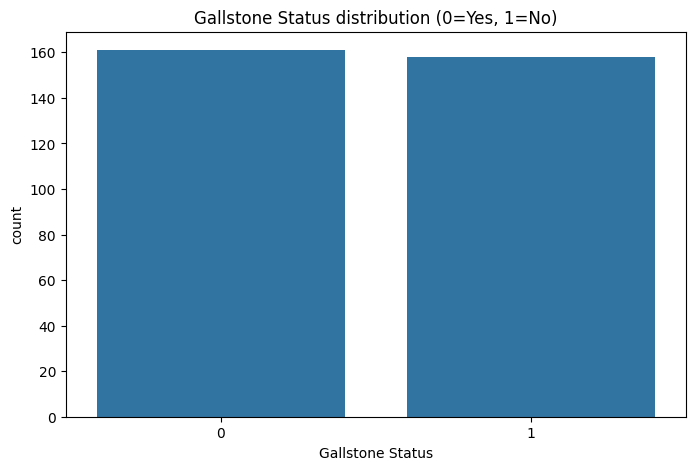

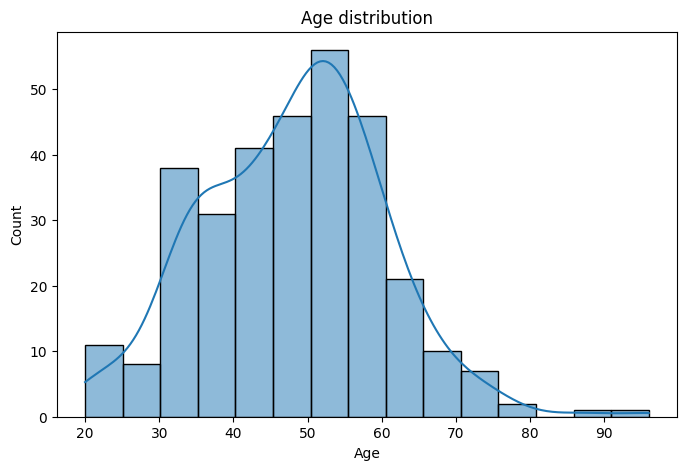

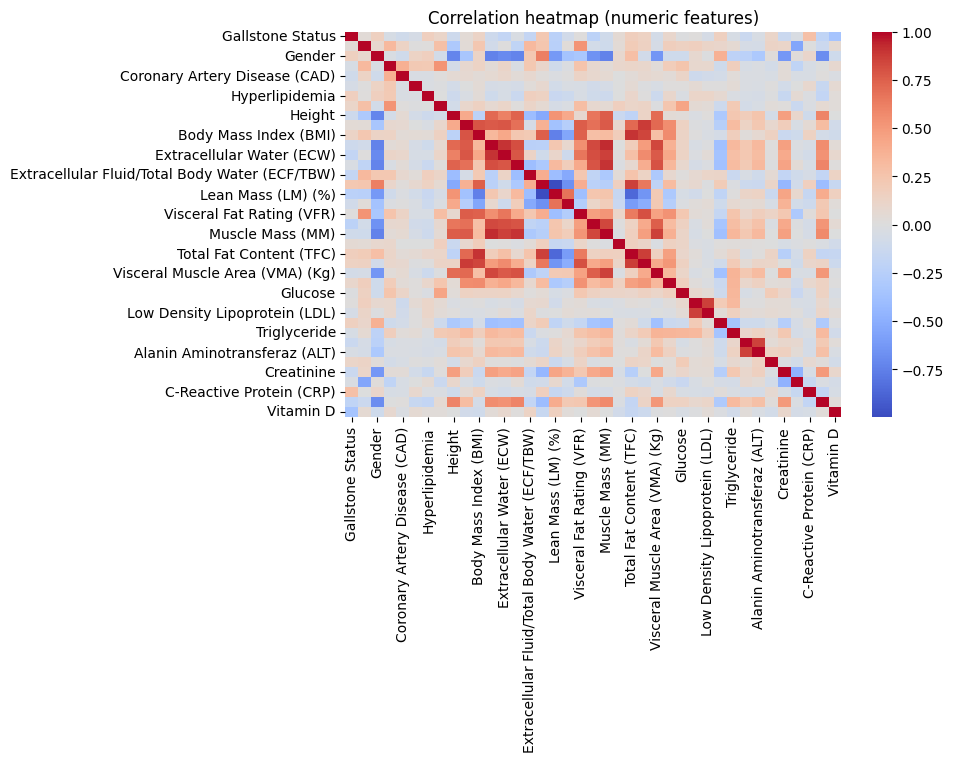

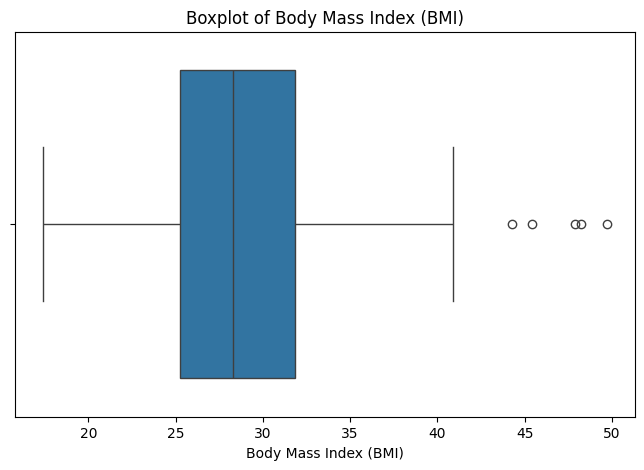


Group-wise means (first 6 numeric cols):


,Age,Gender,Comorbidity,Coronary Artery Disease (CAD),Hypothyroidism,Hyperlipidemia
Gallstone Status,,,,,,
0,47.633540,0.416149,0.360248,0.055901,0.037267,0.000000
1,48.512658,0.569620,0.310127,0.018987,0.018987,0.050633


In [15]:
# 3) Visualizations — tuned to this dataset
if df is not None:
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print('Numeric columns count:', len(numeric_cols))

    # 0. Target distribution
    if 'Gallstone Status' in df.columns:
        sns.countplot(x=df['Gallstone Status'])
        plt.title('Gallstone Status distribution (0=Yes, 1=No)')
        plt.show()

    # 1. Histogram of Age (if present)
    age_col = None
    for cand in df.columns:
        if cand.strip().lower() == 'age':
            age_col = cand
            break
    if age_col is not None and pd.api.types.is_numeric_dtype(df[age_col]):
        sns.histplot(df[age_col], kde=True)
        plt.title('Age distribution')
        plt.xlabel(age_col)
        plt.show()

    # 2. Correlation heatmap (numeric features)
    if len(numeric_cols) > 1:
        corr = df[numeric_cols].corr()
        sns.heatmap(corr, cmap='coolwarm', center=0)
        plt.title('Correlation heatmap (numeric features)')
        plt.show()

    # 3. Boxplot of BMI or a key numeric feature if present
    bmi_like = [c for c in df.columns if 'bmi' in c.lower()]
    feature_for_box = bmi_like[0] if bmi_like else (numeric_cols[0] if numeric_cols else None)
    if feature_for_box is not None:
        sns.boxplot(x=df[feature_for_box])
        plt.title(f'Boxplot of {feature_for_box}')
        plt.show()

    # Group-wise means by target for a handful of features
    if 'Gallstone Status' in df.columns and len(numeric_cols) > 0:
        take = [c for c in numeric_cols if c != 'Gallstone Status'][:6]
        print('\nGroup-wise means (first 6 numeric cols):')
        display(df.groupby('Gallstone Status')[take].mean())
else:
    print('No dataframe to visualize.')


In [16]:
# 4) Preprocessing: target mapping, split, scale (updated for dataset)
if df is None:
    raise SystemExit('Data not loaded — stop here')

# Normalize column names to strip whitespace
df.columns = [c.strip() for c in df.columns]

# Target column
if 'Gallstone Status' not in df.columns:
    raise KeyError('Target column "Gallstone Status" not found')

# Map target: dataset definition says 0 = Yes (disease), 1 = No
# We'll model y=1 as Gallstone present for standard positive class
y = (df['Gallstone Status'] == 0).astype(int)
print('Target mapping: 1 = Gallstone Yes (original 0), 0 = Gallstone No (original 1)')
print('y value counts:\n', y.value_counts())

# Features: drop only the target
X = df.drop(columns=['Gallstone Status']).copy()

# Ensure all remaining columns are numeric (after earlier conversion)
obj_cols = X.select_dtypes(include=['object']).columns.tolist()
if obj_cols:
    # try a final numeric coercion
    for c in obj_cols:
        X[c] = pd.to_numeric(X[c].astype(str).str.replace(',', '.', regex=False), errors='coerce')
    still_obj = X.select_dtypes(include=['object']).columns.tolist()
    if still_obj:
        print('Dropping non-numeric columns (none expected):', still_obj)
        X = X.drop(columns=still_obj)

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
print('Numeric features used:', len(numeric_features))
X = X[numeric_features].copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train/test shapes:', X_train.shape, X_test.shape)

# Scaling (standardize all numeric features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler for later use
joblib.dump(scaler, 'scaler.joblib')


Target mapping: 1 = Gallstone Yes (original 0), 0 = Gallstone No (original 1)
y value counts:
 Gallstone Status
1    161
0    158
Name: count, dtype: int64
Numeric features used: 38
Train/test shapes: (255, 38) (64, 38)


['scaler.joblib']

Top features:
C-Reactive Protein (CRP)                          0.166385
Vitamin D                                         0.082490
Aspartat Aminotransferaz (AST)                    0.039852
Extracellular Fluid/Total Body Water (ECF/TBW)    0.036894
Alkaline Phosphatase (ALP)                        0.033524
Extracellular Water (ECW)                         0.032628
Body Protein Content (Protein) (%)                0.031429
Total Body Fat Ratio (TBFR) (%)                   0.030030
Lean Mass (LM) (%)                                0.029628
Obesity (%)                                       0.028935
dtype: float64


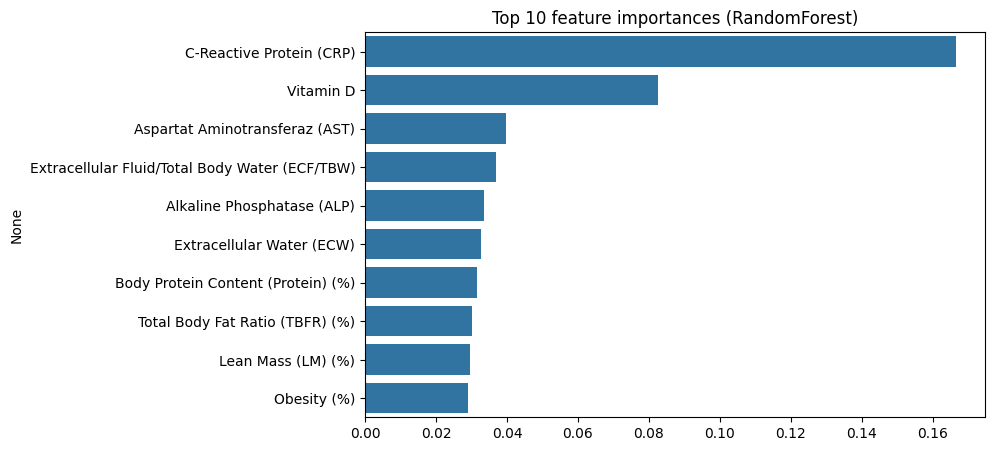

Selected features: ['C-Reactive Protein (CRP)', 'Vitamin D', 'Aspartat Aminotransferaz (AST)', 'Extracellular Fluid/Total Body Water (ECF/TBW)', 'Alkaline Phosphatase (ALP)', 'Extracellular Water (ECW)', 'Body Protein Content (Protein) (%)', 'Total Body Fat Ratio (TBFR) (%)', 'Lean Mass (LM) (%)', 'Obesity (%)', 'Hemoglobin (HGB)', 'Visceral Fat Area (VFA)', 'Total Fat Content (TFC)', 'Low Density Lipoprotein (LDL)', 'Visceral Muscle Area (VMA) (Kg)']


In [17]:
# 5) Feature importance / selection using RandomForest
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=numeric_features).sort_values(ascending=False)
print('Top features:')
print(feat_imp.head(10))

# Plot top 10
sns.barplot(x=feat_imp.head(10).values, y=feat_imp.head(10).index)
plt.title('Top 10 feature importances (RandomForest)')
plt.show()

# Option: select top k features
TOP_K = min(15, len(feat_imp))
top_features = feat_imp.head(TOP_K).index.tolist()
X_train_sel = pd.DataFrame(X_train_scaled, columns=numeric_features)[top_features]
X_test_sel = pd.DataFrame(X_test_scaled, columns=numeric_features)[top_features]
print('Selected features:', top_features)


Training LogisticRegression
LogisticRegression — acc: 0.734, prec: 0.714, rec: 0.781, f1: 0.746, auc: 0.8486328125
              precision    recall  f1-score   support

No Gallstone       0.76      0.69      0.72        32
   Gallstone       0.71      0.78      0.75        32

    accuracy                           0.73        64
   macro avg       0.74      0.73      0.73        64
weighted avg       0.74      0.73      0.73        64



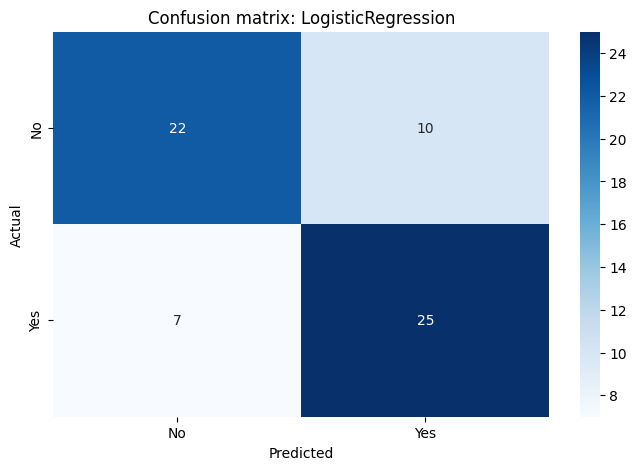

Training DecisionTree
DecisionTree — acc: 0.641, prec: 0.645, rec: 0.625, f1: 0.635, auc: 0.640625
              precision    recall  f1-score   support

No Gallstone       0.64      0.66      0.65        32
   Gallstone       0.65      0.62      0.63        32

    accuracy                           0.64        64
   macro avg       0.64      0.64      0.64        64
weighted avg       0.64      0.64      0.64        64



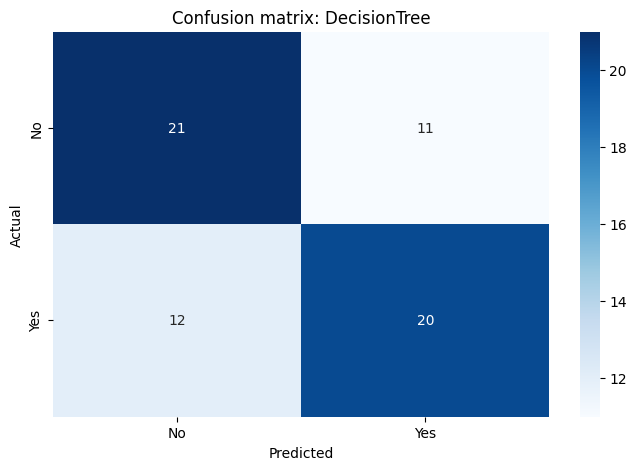

Training RandomForest
RandomForest — acc: 0.750, prec: 0.750, rec: 0.750, f1: 0.750, auc: 0.83056640625
              precision    recall  f1-score   support

No Gallstone       0.75      0.75      0.75        32
   Gallstone       0.75      0.75      0.75        32

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64

RandomForest — acc: 0.750, prec: 0.750, rec: 0.750, f1: 0.750, auc: 0.83056640625
              precision    recall  f1-score   support

No Gallstone       0.75      0.75      0.75        32
   Gallstone       0.75      0.75      0.75        32

    accuracy                           0.75        64
   macro avg       0.75      0.75      0.75        64
weighted avg       0.75      0.75      0.75        64



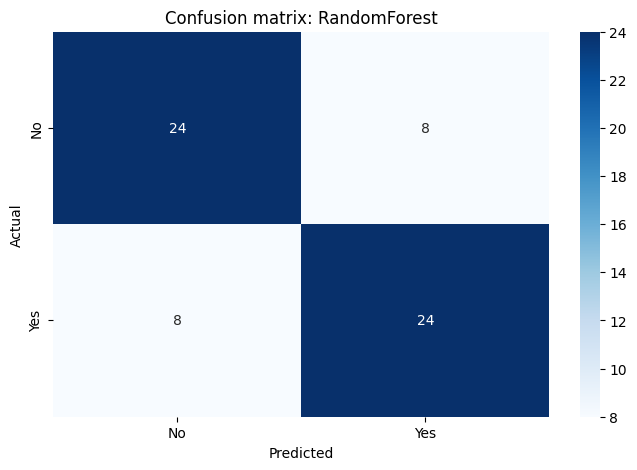

Best model by F1: RandomForest {'model': RandomForestClassifier(n_estimators=300, random_state=42), 'acc': 0.75, 'prec': 0.75, 'rec': 0.75, 'f1': 0.75, 'auc': 0.83056640625}


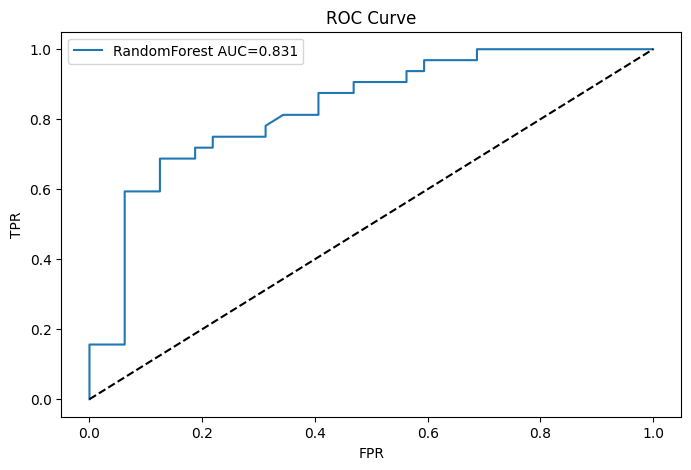

In [18]:
# 6) Train and evaluate at least 3 models (updated)
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_estimators=300)
}

results = {}
for name, model in models.items():
    print('Training', name)
    model.fit(X_train_sel, y_train)
    y_pred = model.predict(X_test_sel)
    y_prob = model.predict_proba(X_test_sel)[:,1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    print(f"{name} — acc: {acc:.3f}, prec: {prec:.3f}, rec: {rec:.3f}, f1: {f1:.3f}, auc: {auc}")
    print(classification_report(y_test, y_pred, zero_division=0, target_names=['No Gallstone','Gallstone']))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No','Yes'], yticklabels=['No','Yes'])
    plt.title(f'Confusion matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    results[name] = {'model': model, 'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'auc': auc}

# Choose best by F1
best_model_name = max(results.keys(), key=lambda k: results[k]['f1'])
best_model = results[best_model_name]['model']
print('Best model by F1:', best_model_name, results[best_model_name])
joblib.dump(best_model, 'best_model.joblib')

# Optional ROC curve for best model
if hasattr(best_model, 'predict_proba'):
    y_prob = best_model.predict_proba(X_test_sel)[:,1]
    fpr, tpr, thresh = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{best_model_name} AUC={roc_auc_score(y_test, y_prob):.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


In [19]:
# 7) Hyperparameter tuning example (RandomForest)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1)
grid.fit(X_train_sel, y_train)
print('Best params:', grid.best_params_)
best_rf = grid.best_estimator_
# Evaluate
y_pred = best_rf.predict(X_test_sel)
print('Grid RF F1:', f1_score(y_test, y_pred))
joblib.dump(grid, 'rf_grid.joblib')


Best params: {'max_depth': 10, 'n_estimators': 200}
Grid RF F1: 0.75


['rf_grid.joblib']

In [20]:
# 8) Sample predictions on unseen rows
# Load best saved model if available
try:
    model = joblib.load('best_model.joblib')
    print('Loaded best_model.joblib')
except Exception:
    model = best_rf if 'best_rf' in globals() else best_model

# Predict on test
y_pred = model.predict(X_test_sel)
probs = model.predict_proba(X_test_sel)[:,1] if hasattr(model, 'predict_proba') else None
res_df = X_test_sel.copy()
res_df['true'] = y_test.values
res_df['pred'] = y_pred
if probs is not None:
    res_df['prob'] = probs

print('Sample predictions:')
display(res_df.head())


Loaded best_model.joblib
Sample predictions:


,C-Reactive Protein (CRP),Vitamin D,Aspartat Aminotransferaz (AST),Extracellular Fluid/Total Body Water (ECF/TBW),Alkaline Phosphatase (ALP),Extracellular Water (ECW),Body Protein Content (Protein) (%),Total Body Fat Ratio (TBFR) (%),Lean Mass (LM) (%),Obesity (%),Hemoglobin (HGB),Visceral Fat Area (VFA),Total Fat Content (TFC),Low Density Lipoprotein (LDL),Visceral Muscle Area (VMA) (Kg),true,pred,prob
0,-0.261723,0.313538,-0.401088,0.568020,-0.988053,1.015893,0.153341,0.414489,-0.401132,0.097382,0.651877,1.182994,0.769870,0.462171,0.852456,1,1,0.723333
1,-0.365493,0.720918,1.356161,-0.699188,0.167412,1.555322,-0.549506,-0.157471,0.159295,0.081006,1.087244,1.087234,0.447083,0.588410,1.614019,1,1,0.836667
2,-0.365493,-0.544029,-0.346174,0.251218,-0.721407,-1.173553,-0.527679,0.152341,-0.148344,-0.220305,-0.218857,-0.751360,-0.521277,-1.052690,0.420217,0,0,0.423333
3,-0.365493,0.104410,-0.181432,-0.382386,-1.032494,0.190884,0.314865,-1.015412,1.016630,-0.199836,0.978402,-0.578992,-0.885714,0.411676,0.113291,0,1,0.613333
4,-0.233422,-0.367182,-0.346174,0.568020,1.100672,1.555322,-0.265748,0.092761,-0.701617,-0.196151,0.543035,1.219383,0.707395,0.689401,0.035197,0,0,0.290000


# 9) Conclusion
"""
Summary:
- Dataset loaded and inspected.
- Visualizations provided insights (distributions, correlations).
- Preprocessing applied: encoding, scaling, feature selection.
- Trained Logistic Regression, Decision Tree, Random Forest (and tuned RF).
- Best model saved to `best_model.joblib` and scaler to `scaler.joblib`.

Next steps:
- More careful feature engineering and domain-guided selection.
- Cross-validated performance reporting (more folds).
- Model interpretability (SHAP, LIME) for clinical trust.
"""
